In [1]:
import os
import sys
sys.path.append('..')
os.chdir('..')

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as nnf
import cv2
import glob
import json
import time

from configs.config_parser import Config

from model.AuxilaryNet import UNet

def prepare_plot(origImage, origMask, predMask):

    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

    ax[0].imshow(origImage,cmap = 'gray')
    ax[1].imshow(origMask, cmap = 'jet', vmin = 0, vmax = 255)
    ax[2].imshow(predMask, cmap = 'jet', vmin = 0, vmax = 255)

    ax[0].set_title("Image")
    ax[1].set_title("Original Mask")
    ax[2].set_title("Predicted Mask")

    figure.tight_layout()
    plt.show()


def make_predictions(model, imid):

    model.eval()

    with torch.no_grad():
        image = cv2.imread(f'{conf.IMAGE_DATASET_PATH}/{imid}.png', 0)
        image = image.astype("float32") / 255.0
        orig = image.copy()
        gtMask = cv2.imread(f'{conf.MASK_DATASET_PATH}/{imid}.png', 0)

        image = np.expand_dims(image, 0)
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to('cuda:0')

        predLabel, predMask = model(image)
        predMask = predMask.squeeze(0).squeeze(0)
        
        predMask = torch.relu(torch.sign(torch.sigmoid(predMask)-0.5)) * 255
        predMask = predMask.cpu().numpy()
        predMask = predMask.astype(np.uint8)
        # predMask = predMask[0]
        
        
        # # prepare a plot for visualization
        # prob = nnf.softmax(predLabel, dim=1)
        # prob = prob.cpu().detach().numpy().squeeze(0)
        # prob = np.round(prob, decimals=3)
        # predCls = np.argmax(prob)
        
        # if predCls == 0 and prob[predCls] > 0.5:
        #     predMask = np.zeros((512,512))
        #     print(prob, 'BU')
        # elif predCls == 1 and prob[predCls] > 0.5:
        #     predMask = np.ones((512,512)) * 255
        #     predMask = predMask.astype(np.uint8)
        #     print(prob, 'NPLD')
        # else:
        #     print(prob, 'SCARP')
        
        # if predCls == 0 and prob[predCls] > 0.8:
        #     print(prob, 'BU')
        # elif predCls == 1 and prob[predCls] > 0.8:
        #     print(prob, 'NPLD')
        # else:
        #     print(prob, 'SCARP')

        prepare_plot(orig, gtMask, predMask)

[INFO] loading up test image paths...
[INFO] MODEL: AuxNet, MODE: encoder, DATASET: scarp, FREEZING: ['out1'], LOSS: segmentation
[INFO] load up model...


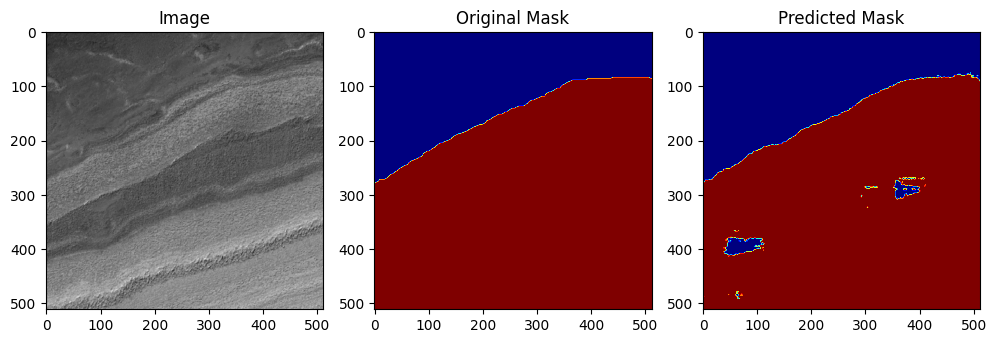

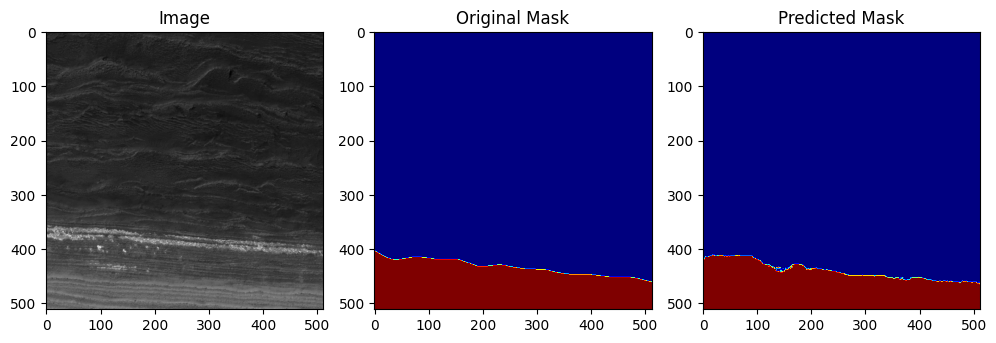

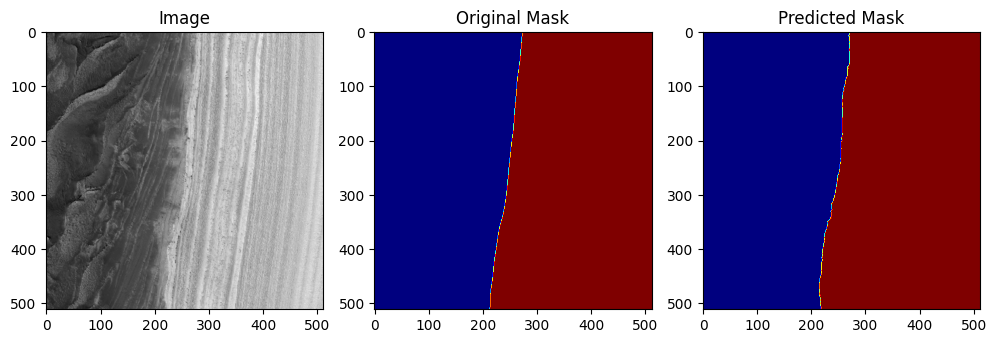

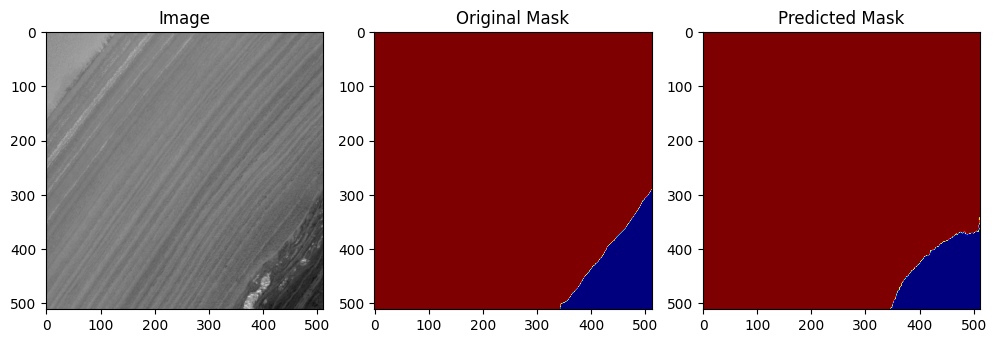

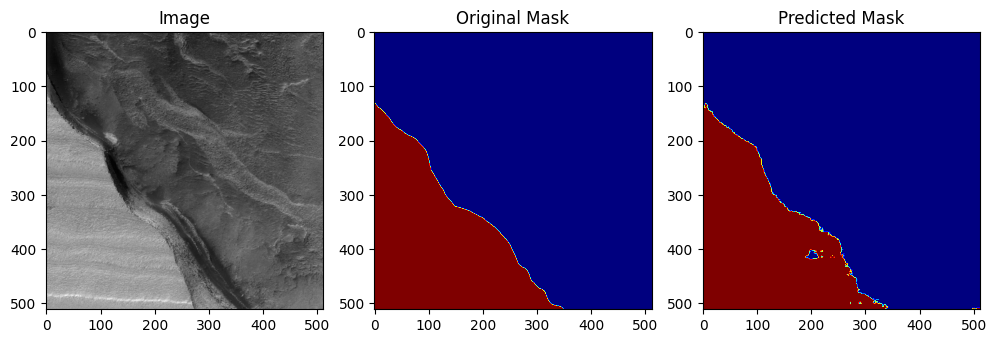

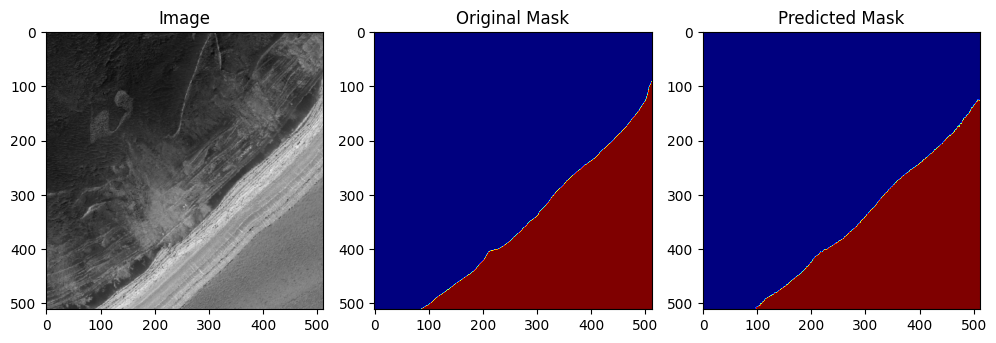

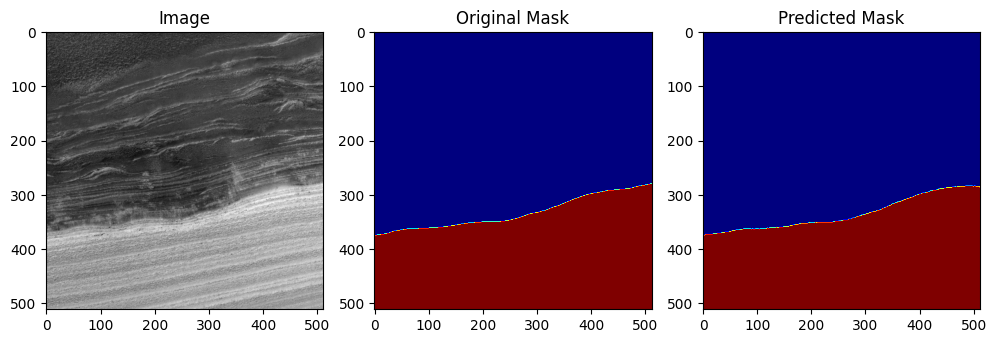

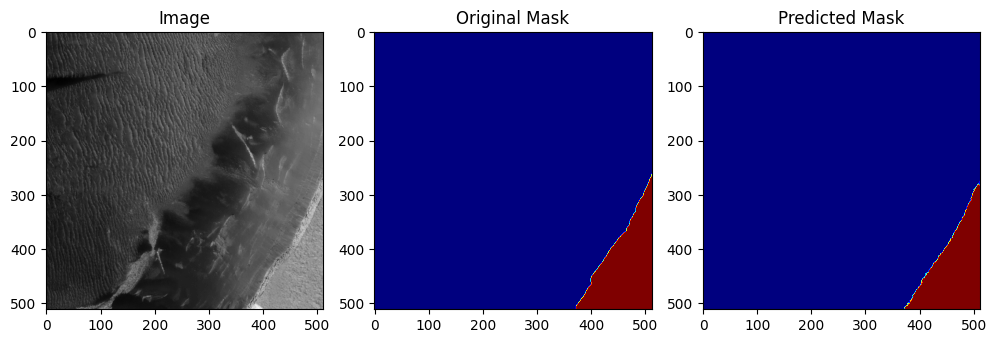

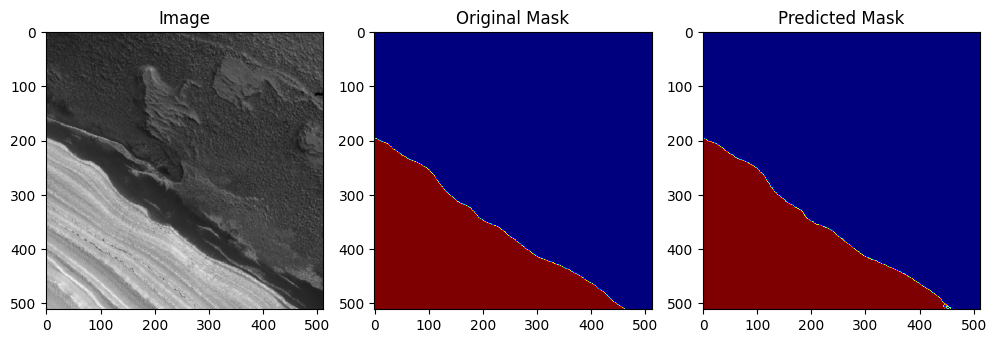

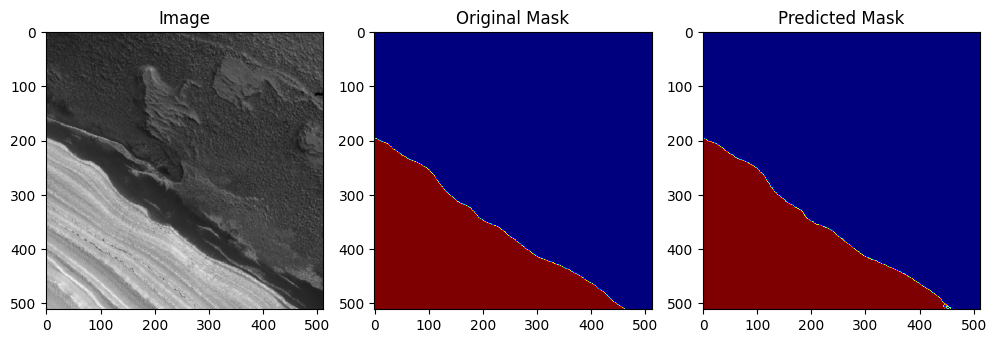

In [5]:
print("[INFO] loading up test image paths...")
conf = Config().getConfig()

TTS = json.load(open(conf.TTS_PATH))
imageIDs = TTS['testIDs']
imageIDs = np.random.choice(imageIDs, size=10)

print("[INFO] load up model...")
unet = UNet(conf).to('cuda:0')
unet.load_state_dict(torch.load(conf.SAVEPATH)['state_dict'])

for imid in imageIDs:
    make_predictions(unet, imid)